In [47]:
import investpy
import pandas as pd
from time import sleep
from urllib.error import HTTPError
import investiny
from investiny import historical_data
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, LinearLocator
import textwrap


from reportlab.platypus import SimpleDocTemplate, PageTemplate, Frame, Flowable, Paragraph, Table, TableStyle, Spacer, KeepTogether  
from reportlab.lib.enums import TA_JUSTIFY, TA_CENTER  
from reportlab.lib import colors
from reportlab.pdfbase import pdfmetrics  
from reportlab.pdfbase.ttfonts import TTFont  
from io import BytesIO  
from svglib.svglib import svg2rlg  
from reportlab.lib.styles import ParagraphStyle
from reportlab.lib.styles import getSampleStyleSheet



In [48]:
equities_DF = pd.read_csv(r'C:\Users\bhavy\Desktop\Pandas project\Portfolio Project\Investments CSV Example.csv', sep=',', header=0, index_col=0).dropna(how='all')
equities_DF

,No.,Bought,Sold,Cost,Revenue,Profit/Loss,Return %,InvestPy Fund Name,ISIN for Yahoo Finance,Stock Ticker
Shares/Equity,,,,,,,,,,
Chelverton UK Equity Income Class B - Accumulation (GBP),"1,714.97",05/09/2017,14/01/2020,"£4,000.00","£12,345.15","£1,345.15",12.23%,NaN,0P0000KO3C.L,NaN
Chelverton UK Equity Income Class B - Accumulation (GBP),"2,997.09",17/10/2018,14/01/2020,"£7,000.00",NaN,NaN,NaN,NaN,NaN,NaN
Baillie Gifford Japanese Smaller Companies Class B - Income (GBP),165.955,08/01/2018,14/01/2020,"£7,000.00","£7,640.27",£640.27,9.15%,NaN,0P00000QWD.L,NaN
Baillie Gifford Global Discovery Class B - Accumulation (GBP),449.871,25/07/2018,25/02/2020,"£7,000.00","£7,805.26",£805.26,11.50%,NaN,0P00000VC8.L,NaN
Baillie Gifford Global Stewardship Class B - Accumulation (GBP),893.655,16/01/2020,25/02/2020,"£5,000.00","£5,033.96",£33.96,0.68%,NaN,0P000174DQ.L,NaN


In [49]:
equities_DF['Bought'] = pd.to_datetime(equities_DF['Bought'], format='%d/%m/%Y')
equities_DF['Sold'] = pd.to_datetime(equities_DF['Sold'], format='%d/%m/%Y')
equities_DF['Buffer'] = (equities_DF['Sold'] - equities_DF['Bought']) * 0.2
equities_DF['Interval'] = equities_DF['Sold'] - equities_DF['Bought']
equities_DF['Bought_search'] = equities_DF['Bought'] - equities_DF['Buffer']
equities_DF['Sold_search'] = equities_DF['Sold'] + equities_DF['Buffer']

In [50]:
equities_DF['Bought_ts'] = ((equities_DF['Bought_search'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')).astype('Int64')  # Int64 is a special pandas type that supports nullable Ints.
equities_DF['Sold_ts'] = ((equities_DF['Sold_search'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')).astype('Int64')


In [51]:
prices = {}    
def fetch_prices():
    print('"def_prices"')
    consecutive_trades = ''  
    consecutive_trades_I = ''  
    for equity in enumerate(equities_DF.index):
         #CHECKPOINT     1-----------------------------------------------
        print('Checkpoint 1')
        if equity[1] not in prices:
            prices[equity[1]] = equities_DF.iloc[equity[0], 7:10].dropna().to_dict()
            #print( equity[0])
            consecutive_trades = equity[1]
            #print(consecutive_trades)
        elif equity[1] == consecutive_trades:  
            prices[equity[1]]['Additional buy'] = equities_DF.iloc[equity[0], 1]
            consecutive_trades = equity[1]
            #print('"Additional ELIF"')
        
        #CHECKPOINT     2-----------------------------------------------
        print('CHECKPOINT 2')
        country = 'United Kingdom'
        if 'USD' in equity[1]:
            country = 'United States'
        elif 'CAD' in equity[1]:
            country = 'Canada'



        if equity[1]==consecutive_trades_I:
            print(f'{equity[0]}. Additional buy for {equity[1]} - skipped')
            continue
        elif 'InvestPy Fund Name' in prices[equity[1]]:
            search_name=prices[equity[1]]['InvestPy Fund Name']
            try:
                prices[equity[1]]['Price History']=investpy.get_stock_historical_data(stock=search_name,
                                                                                      country=country,
                                                                                      from_date=equities_DF.iloc[equity[0],-4].strftime('%dd/%mm/%yyyy'),
                                                                                      to_date=equities_DF.iloc[equity[0],-3].strftime('%dd/%mm/%yyyy'),
                                                                                      interval='Daily')
                print(f'{equity[0]}. Retrived Fund price data for {equity[1]}')
            except:
                print(RuntimeError,f'Unsuccessful to retrieve data from Investpy for {equity[1]}')
    
        elif 'Stock Ticker' in prices[equity[1]]:
            search_name=prices[equity[1]]['Stock Ticker']
            try:
                prices[equity[1]]['Price History']=investpy.get_stock_historical_data(stock=search_name,
                                                                                      country=country,
                                                                                      from_date=equities_DF.iloc[equity[0],-4].strftime('%dd/%mm/%yyyy'),
                                                                                      to_date=equities_DF.iloc[equity[0],-3].strftime('%dd/%mm/%yyyy'),
                                                                                      interval='Daily')
                print(f'{equity[0]}. Retrived Fund price data for {equity[1]}')


            except RuntimeError:                
                prices[equity[1]]['Price History']=pd.read_csv(f'https://query1.finance.yahoo.com/v11/finance/download/{search_name}?period1={equities_DF.iloc[equity[0], -2]}&period2={equities_DF.iloc[equity[0], -1]}&interval=1d&events=history', index_col='Date')
                prices[equity[1]]['Price History'].index=pd.to_datetime(prices[equity[1]]['Price History'].index, format='%Y-%m-%d')
                print(f'{equity[0]}. Retrieved Stock Price data for {equity[1]} from YF.')
                sleep(1)
            except HTTPError:
                print('Unseccessful to Retrieve Data from Yahoo Finance for', equity[1])
    
        elif 'ISIN for Yahoo Finance' in prices[equity[1]]:
            search_name=prices[equity[1]]['ISIN for Yahoo Finance']
            try:
                prices[equity[1]]['Price History']=pd.read_csv(f'https://query1.finance.yahoo.com/v7/finance/download/{search_name}.L?period1={equities_DF.iloc[equity[0], -2]}&period2={equities_DF.iloc[equity[0], -1]}&interval=1d&events=history', index_col='Date')
                prices[equity[1]]['Price History'].index=pd.to_datetime(prices[equity[1]]['Price History'].index, format=='%Y-%m-%d')
                print(f'{equity[0]}. Retrieved fund price data for {equity[1]} using ISIN.')
                sleep(1)
            except HTTPError:
                try:
                    prices[equity[1]]['Price History'] = pd.read_csv(f'https://query1.finance.yahoo.com/v7/finance/download/{search_name}.L?period1={equities_DF.iloc[equity[0], -2]}&period2={equities_DF.iloc[equity[0], -1]}&interval=1d&events=history', index_col='Date')
                    prices[equity[1]]['Price History'].index = pd.to_datetime(prices[equity[1]]['Price History'].index, format='%Y-%m-%d')  # Convert index to datetime
                    print(f'{equity[0]}. Retrieved fund price data for {equity[1]} using ISIN.')
                    sleep(1)
                except HTTPError:
                     print('Unseccessful to Retrieve Data from Yahoo Finance for', equity[1])
            
            except Exception as UnknownError:
                print('Unkown error for',equity[1], UnknownError)
        
        else:
            print(f'{equity[0]}. No prive data for this equity found - skipped')
        consecutive_trades_I=equity[1]
        try:
            prices[equity[1]]['Price History'].loc[prices[equity[1]]['price History']['Close']<prices[equity[1]]['Price History']['Close'].max()/100,['Open','High','Low','Close']]*=100
        except KeyError:
            print(KeyError,' THis equity had no price data')


fetch_prices()

"def_prices"
Checkpoint 1
CHECKPOINT 2
Unseccessful to Retrieve Data from Yahoo Finance for Chelverton UK Equity Income Class B - Accumulation (GBP)
<class 'KeyError'>  THis equity had no price data
Checkpoint 1
CHECKPOINT 2
1. Additional buy for Chelverton UK Equity Income Class B - Accumulation (GBP) - skipped
Checkpoint 1
CHECKPOINT 2
Unseccessful to Retrieve Data from Yahoo Finance for Baillie Gifford Japanese Smaller Companies Class B - Income (GBP)
<class 'KeyError'>  THis equity had no price data
Checkpoint 1
CHECKPOINT 2
Unseccessful to Retrieve Data from Yahoo Finance for Baillie Gifford Global Discovery Class B - Accumulation (GBP)
<class 'KeyError'>  THis equity had no price data
Checkpoint 1
CHECKPOINT 2
Unseccessful to Retrieve Data from Yahoo Finance for Baillie Gifford Global Stewardship Class B - Accumulation (GBP)
<class 'KeyError'>  THis equity had no price data


In [52]:
if not os.path.isfile('./prices_2019-20.pkl'):
    fetch_prices()

def save_prices(prices_dict, filename):
    with open(filename,'wb') as filepath:
        pickle.dump(prices_dict, filepath, pickle.HIGHEST_PROTOCOL)

if not os.path.isfile('./prices_2019-20.pkl'):
    save_prices(prices,'./prices_2019-20.pkl')

def load_prices(filename):
    with open(filename,'rb') as file:
        prices=pickle.load(file)
    return prices

if os.path.isfile('./prices_2019-20.pkl'):
    load_prices('./prices_2019-20.pkl')
    

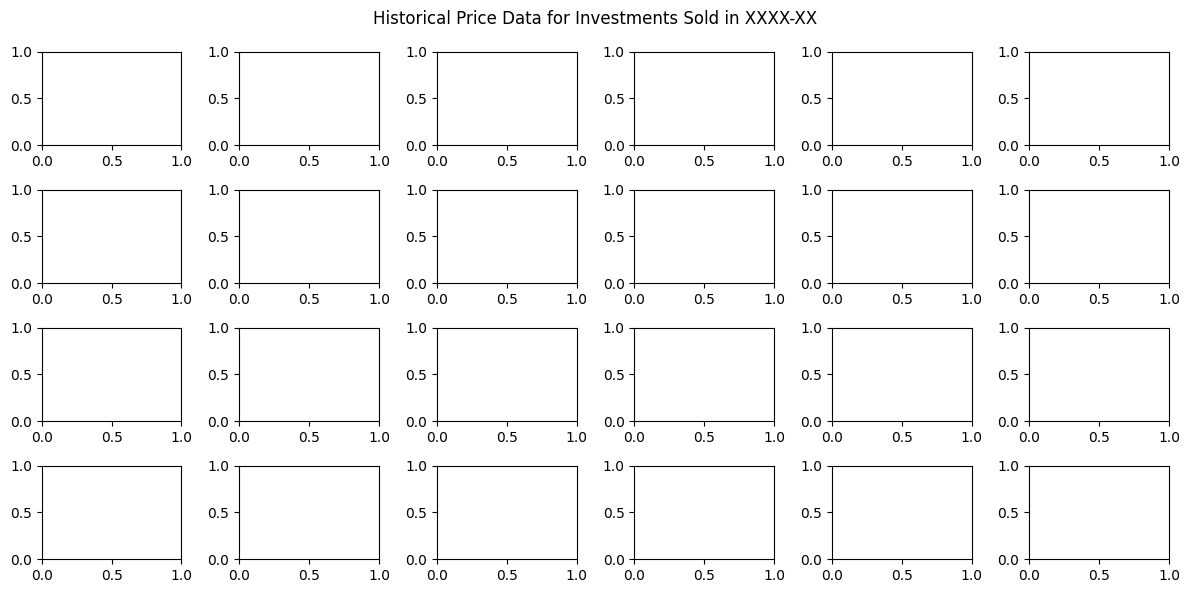

In [53]:
def overview_plots():
    fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(12, 6), tight_layout=True)
    fig.suptitle(f'Historical Price Data for Investments Sold in XXXX-XX')
    monthYear = mdates.DateFormatter('%b-%y')
    dayMonthYear = mdates.DateFormatter('%d/%m/%y')
    for ax, (equity_name, equity) in zip(axs.flat, prices.items()):
        if equity.get('Price History') is not None:
            ax.set_title("\n".join(textwrap.wrap(equity_name, 45)), fontsize=6, wrap=True)  
            
            ax.plot(equity['Price History'].index, equity['Price History']['Close'], color='blue', linewidth=1)
            ax.tick_params(labelsize=4)
            ax.set_xlabel('Date', fontsize=5)
            ax.set_ylabel('Price', fontsize=5)
            locator = MaxNLocator(nbins='auto')  
            numticks = LinearLocator(numticks=6)  
            ax.yaxis.set_major_locator(locator)
            ax.xaxis.set_major_locator(numticks)
            
            interval = equities_DF.loc[equity_name, 'Interval']
            if isinstance(interval, pd.Series):  
                interval = equities_DF.loc[equity_name, 'Interval'][0]
            if interval < pd.Timedelta(60, 'days'):
                ax.xaxis.set_major_formatter(dayMonthYear)
                ax.tick_params(axis='x', labelrotation=30)
            else:
                ax.xaxis.set_major_formatter(monthYear)
            
            bought_date = equities_DF.loc[equity_name, 'Bought']
            sold_date = equities_DF.loc[equity_name, 'Sold']
            if isinstance(bought_date, pd.Series):
                bought_date = bought_date[0]
                sold_date = sold_date[0]
            
            bought_ycoord = prices[equity_name]['Price History'].loc[bought_date, 'Close']
            sold_ycoord = prices[equity_name]['Price History'].loc[sold_date, 'Close']
            if not pd.isna([bought_ycoord, sold_ycoord]).any():
                ax.annotate('Bought', (bought_date, bought_ycoord), xycoords='data', fontsize=5, fontweight='semibold', color='orange', xytext=(-15, -25), textcoords='offset points', arrowprops={'arrowstyle': '->'})
                ax.annotate('Sold', (sold_date, sold_ycoord), xycoords='data', fontsize=5, fontweight='semibold', color='red', xytext=(-15, -25), textcoords='offset points', arrowprops={'arrowstyle': '->'})
            else:
                pass
        else:
            continue

overview_plots()

In [54]:
def draw_static_elements(canvas, pdf_doc):
    canvas.saveState() 
    canvas.setFont('Vera', 10)
    canvas.drawString(30, 810, f'Report generated on {pd.to_datetime("today"):%d/%m/%Y}')
    canvas.restoreState()

def scale_to_fit(drawing, pdf_doc):
    """This function scales the drawing object to fit within the margin width of the pdf SampleDocTemplate"""
    max_width = pdf_doc.width
    scale_factor = max_width / drawing.width
    drawing.width *= scale_factor
    drawing.height *= scale_factor
    drawing.scale(scale_factor, scale_factor)
    drawing.hAlign = 'RIGHT'
    return drawing

class Line(Flowable):  
    def __init__(self, width, height=0):  
        Flowable.__init__(self)
        self.width = width
        self.height = height

    def __repr__(self):
        return f"Line with width={self.width}"

    def draw(self):
        """Use canvas.line method. Provide two X,Y pairs for start and end of line."""
        self.canv.line(0, self.height, self.width, self.height)

line = Line(438)  

pdf = SimpleDocTemplate('Report Preview.pdf', topMargin=57, bottomMargin=35, author='Your Name', showBoundary=False)
frame = Frame(pdf.leftMargin, pdf.bottomMargin, pdf.width, pdf.height, showBoundary=False)
template = PageTemplate(frames=[frame], onPage=draw_static_elements)
pdf.addPageTemplates(template)
styles = getSampleStyleSheet()
pdfmetrics.registerFont(TTFont('Vera', 'Vera.ttf'))
styles.add(ParagraphStyle(name='MainTitle', fontName='Vera', underlineWidth=1, fontSize=16, alignment=TA_CENTER))
styles.add(ParagraphStyle(name='EquityHeading', fontName='Vera', fontSize=12, alignment=TA_JUSTIFY))
styles.add(ParagraphStyle(name='Body', fontName='Vera', fontSize=10, alignment=TA_JUSTIFY))
story = list()
story.append(Paragraph('<u>HL Fund and Share Account Trades: Tax Year XXXX-XX</u>', style=styles['MainTitle']))
story.append(Spacer(5, 30))

monthYear = mdates.DateFormatter('%b-%y')
dayMonthYear = mdates.DateFormatter('%d-%b-%y')
for equity_name, equity in prices.items():
    if equity.get('Price History') is not None:
        fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
        ax.plot(equity['Price History'].index, equity['Price History']['Close'], color='blue', linewidth=1)
        ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)
        ax.tick_params(labelsize=8)
        ax.set_xlabel('Date', fontsize=11)
        ax.set_ylabel('Price', fontsize=11)
        locator = MaxNLocator(nbins='auto')
        numticks = LinearLocator(numticks=8)
        ax.yaxis.set_major_locator(locator)
        ax.xaxis.set_major_locator(numticks)
        interval = equities_DF.loc[equity_name, 'Interval']
        if isinstance(interval, pd.Series):
            interval = equities_DF.loc[equity_name, 'Interval'][0]
        if interval < pd.Timedelta(60, 'days'):
            ax.xaxis.set_major_formatter(dayMonthYear)
        else:
            ax.xaxis.set_major_formatter(monthYear)
        bought_date = equities_DF.loc[equity_name, 'Bought']
        sold_date = equities_DF.loc[equity_name, 'Sold']
        if isinstance(bought_date, pd.Series):
            bought_date = bought_date[0]
            sold_date = sold_date[0]
        bought_ycoord = prices[equity_name]['Price History'].loc[bought_date, 'Close']
        sold_ycoord = prices[equity_name]['Price History'].loc[sold_date, 'Close']
        if not pd.isna([bought_ycoord, sold_ycoord]).any():
            try:
                ax.annotate('Bought', (bought_date, bought_ycoord), xycoords='data', fontsize=10, fontweight='semibold', color='orange', xytext=(-15, -70), textcoords='offset points', arrowprops={'arrowstyle': '->'})
                ax.annotate('Sold', (sold_date, sold_ycoord), xycoords='data', fontsize=10, fontweight='semibold', color='red', xytext=(-15, -70), textcoords='offset points', arrowprops={'arrowstyle': '->'})
            except KeyError:
                print(KeyError, equity_name)
        else:
            pass

        chart = BytesIO()
        fig.savefig(chart, format='svg')
        chart.seek(0)
        chartRL = svg2rlg(chart)
        chartRL = scale_to_fit(chartRL, pdf)

        equityText = Paragraph(f'{equity_name}:', style=styles['EquityHeading'])
        profit_loss = equities_DF.loc[equity_name, 'Profit/Loss']
        return_pc = equities_DF.loc[equity_name, 'Return %']
        if isinstance(profit_loss, pd.Series):
            profit_loss = float(profit_loss[0].replace('£', '').replace(',', ''))
            return_pc = return_pc[0]
        else:
            profit_loss = float(profit_loss.replace('£', '').replace(',', ''))
        if profit_loss > 0:
            profit_loss_color = colors.palegreen
        else:
            profit_loss_color = colors.pink
        table_data = [['', 'Bought', 'Sold', 'Profit/Loss', 'Return %'],
                      [equity_name, bought_date.strftime('%d/%m/%Y'), sold_date.strftime('%d/%m/%Y'), '£' + str(profit_loss), return_pc]]
        table = Table(table_data)
        table.setStyle(TableStyle([('FONTNAME', (0, 0), (-1, -1), 'Vera'),
                                   ('FONTSIZE', (0, 0), (-1, -1), 9),
                                   ('INNERGRID', (0, 0), (-1, -1), 1, colors.grey),
                                   ('BACKGROUND', (3, -1), (4, -1), profit_loss_color)]))

        story.append(KeepTogether([line, Spacer(5, 6),
                                   equityText, Spacer(5, 4),
                                   chartRL, Spacer(5, 2),
                                   table, Spacer(5, 30)]))
    else:
        continue

plt.close('all')

pdf.build(story)